In [15]:
import urllib
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

CASES_DATASET = "VDH-COVID-19-PublicUseDataset-Cases.csv"
COUNTIES = frozenset({"Alexandria", "Arlington","Fairfax"})

cases = pd.read_csv(os.path.join("./data", CASES_DATASET))
cases["Datetime"] = pd.to_datetime(cases["Report Date"])

cases.head()

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,Datetime
0,7/4/2020,51001,Accomack,Eastern Shore,1043,72,14,2020-07-04
1,7/4/2020,51003,Albemarle,Thomas Jefferson,456,34,9,2020-07-04
2,7/4/2020,51005,Alleghany,Alleghany,35,5,2,2020-07-04
3,7/4/2020,51007,Amelia,Piedmont,45,11,1,2020-07-04
4,7/4/2020,51009,Amherst,Central Virginia,37,3,0,2020-07-04


In [16]:
def get_daily_cases_moving_avg(data, counties, avg=7):
    total_cases = pd.DataFrame(
        data[data["Locality"].isin(counties)].groupby("Report Date")["Total Cases"].agg("sum")
    )
    total_cases.reset_index(inplace=True)
    total_cases["Datetime"] = pd.to_datetime(total_cases["Report Date"])
    total_cases.sort_values(by="Datetime", inplace=True)

    total_cases["Daily"] = total_cases["Total Cases"].diff()
    total_cases[f"{avg} day avg"] = total_cases["Daily"].rolling(avg).mean()

    total_cases["pct change"] = total_cases[f"{avg} day avg"].pct_change()
    
    return total_cases


def plot_case_counts(dataframes):
    sns.set(style="white", palette="muted", color_codes=True)
    f, axes = plt.subplots(1, 2, figsize=(20,10))
    
    for label, data in dataframes.items():
        pct_change = data["pct change"].to_list()[-1]
        left = sns.lineplot(x="Datetime", y="Total Cases", data=data, ax=axes[0],label=label)
        right = sns.lineplot(
            x="Datetime", y="7 day avg", data=data, ax=axes[1], label=f"{label} {pct_change*100:.2f}%")

    left.set_title("Cummulative Casses")
    right.set_title("7 day moving average")
    title = (f"Total Cases as of {data.iloc[-1]['Report Date']}\n"
             f"for {', '.join([county for county in dataframes.keys() if county!='Total cases'])}"
            )
    a = f.suptitle(title, fontsize=20)
    plt.show()

In [17]:
dataframes = {
    "Alexandria": get_daily_cases_moving_avg(cases, {"Alexandria"}, avg=7),
    "Fairfax": get_daily_cases_moving_avg(cases, {"Fairfax"}, avg=7),
    "Arlington": get_daily_cases_moving_avg(cases, {"Arlington"}, avg=7),
    "Total cases": get_daily_cases_moving_avg(cases, COUNTIES, avg=7)
}

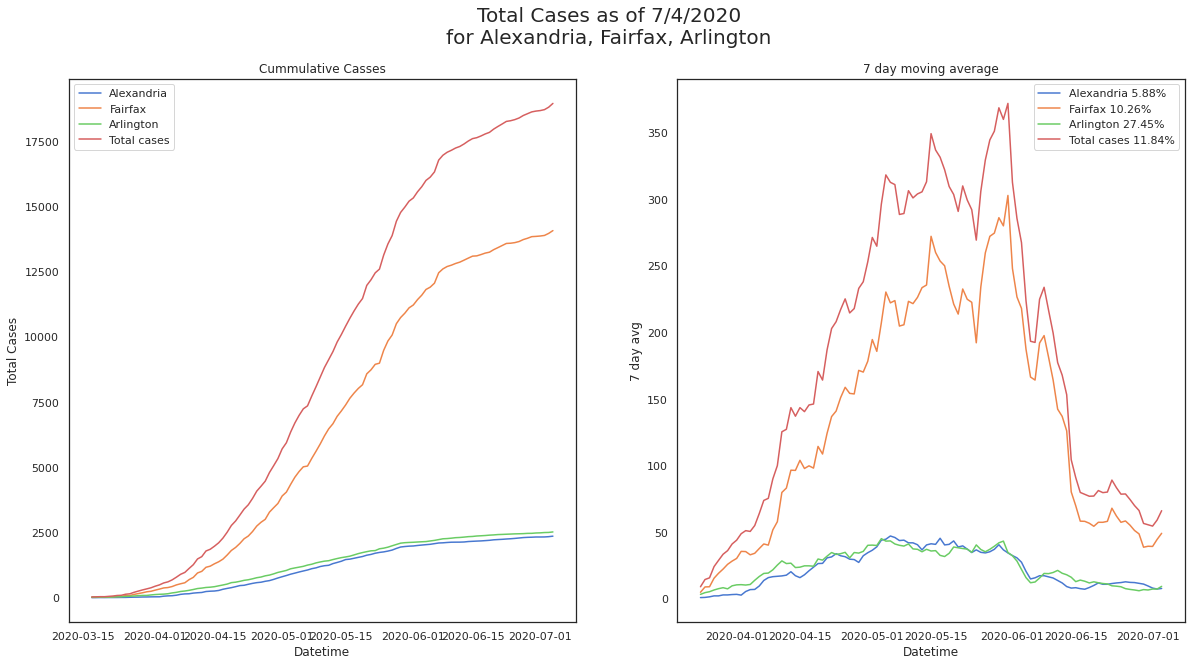

In [18]:
plot_case_counts(dataframes)